# Question 1

he following data warehouse describes the performance of certification courses delivered by an
international certification company. Certification courses are delivered in certification offices,
which are distributed around the world. The offices are also characterized by the number of
classrooms and teachers available. The metrics to be analyzed are the total revenue, the number
of delivered hours, the number of enrolled students, and the number of students who passed the
certification exam at the end of the course (NumberPassed).
The data warehouse stores the main characteristics of courses and related certifications in terms
of topic, delivery mode (attendance, online, blended), type and level (basic, intermediate, or
advanced) of certification, and presence or absence of prerequisites
(PresenceAdmissionRequirements, Boolean attribute). Enrolled students are characterized by age
range (<=20, >21 and <=30, >31 and <=45, >45), profession, and gender (M, F).
The data warehouse is characterized by the following conceptual schema and corresponding
logical schema.

![Screenshot 2024-02-21 175244.png](<attachment:Screenshot 2024-02-21 175244.png>)

```sql
CREATE TABLE FEATURES_COURSE_CERTIFICATION(
    IDFeatCourseCert INT PRIMARY KEY,
    Topic VARCHAR(100),
    CertificationType VARCHAR(50),
    CertificationLevel VARCHAR(50),
    PresenceAdmissionRequirements BOOLEAN,
    DeliveryMode VARCHAR(50)
);

CREATE TABLE ENROLLED_CHARACTERISTICS(
    IDEnrolledChar INT PRIMARY KEY,
    AgeRange VARCHAR(50),
    Profession VARCHAR(100),
    Gender CHAR(1)
);

CREATE TABLE CERTIFICATION_OFFICE(
    IDCertOffice INT PRIMARY KEY,
    CityOffice VARCHAR(50),
    RegionOffice VARCHAR(50),
    CountryOffice VARCHAR(50),
    NumberClassrooms INT,
    NumberTeachers INT
);

CREATE TABLE TEMPO(
    IDTime INT PRIMARY KEY,
    Month INT,
    TwoMonths INT,
    ThreeMonths INT,
    FourMonths INT,
    SixMonths INT,
    Year INT
);

CREATE TABLE COURSES_DELIVERY(
    IDFeatCourseCert INT,
    IDEnrolledChar INT,
    IDCertOffice INT,
    IDTime INT,
    TotalRevenue DECIMAL(10, 2),
    NumberHoursDelivered INT,
    NumberEnrolled INT,
    NumberPassed INT,
    PRIMARY KEY (
        IDFeatCourseCert,
        IDEnrolledChar,
        IDCertOffice,
        IDTime
    ),
    FOREIGN KEY (IDFeatCourseCert) REFERENCES FEATURES_COURSE_CERTIFICATION(IDFeatCourseCert),
    FOREIGN KEY (IDEnrolledChar) REFERENCES ENROLLED_CHARACTERISTICS(IDEnrolledChar),
    FOREIGN KEY (IDCertOffice) REFERENCES CERTIFICATION_OFFICE(IDCertOffice),
    FOREIGN KEY (IDTime) REFERENCES TEMPO(IDTime)
);
```
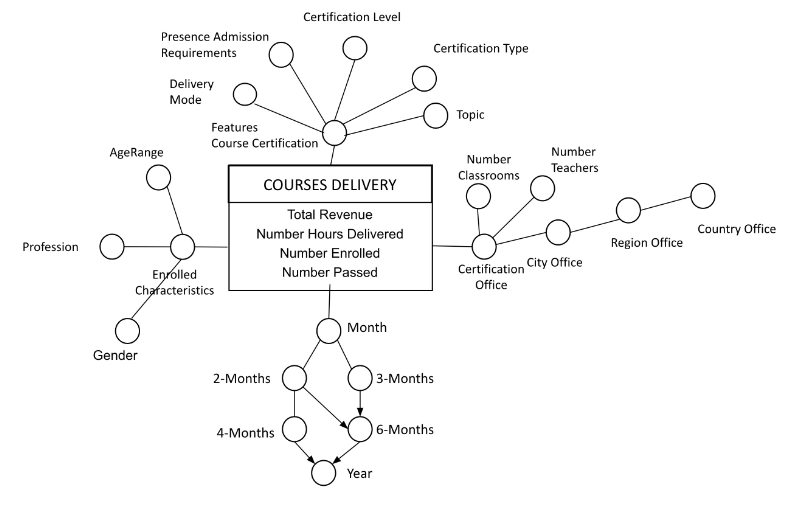

## Query 1

Considering certification offices located in Italy, separately by course delivery mode and 6-months
period, display

- The total number of hours delivered
- The average number of passed students per month
- The ratio of the total number of enrolled students over the total number of enrolled students
separately by year and delivery mode
- The position in a ranking (rank) in descending order with respect to the total number of hours
delivered.

Conduct the analysis separately by topic.

In [ ]:
SELECT
    DeliveryMode,
    SixMonths,
    Topic,
    SUM(NumberHoursDelivered),
    SUM(NumberPassed) / COUNT(DISTINCT Month),
    SUM(NumberEnrolled) / SUM(
        SUM(NumberEnrolled) OVER (
            PARTITION BY Topic, Year, DeliveryMode
        )
    ),
    RANK() OVER (
        PARTITION BY Topic
        ORDER BY SUM(NumberHoursDelivered) DESC
    )
FROM
    CERTIFICATION_OFFICE co,
    COURSES_DELIVERY cd,
    FEATURES_COURSE_CERTIFICATION fcc,
    TIME t
WHERE
    CountryOffice == 'Italy'
    AND cd.IDCertOffice == co.IDCertOffice
    AND cd.IDFeatCourseCert == fcc.IDFeatCourseCert
    AND cd.IDTime == t.IDTime
GROUP BY
    DeliveryMode,
    SixMonths,
    Year,
    Topic,
    Month

## Query 2

Considering courses with online delivery mode, separately by profession, 3-month periods, and
certification office country, display
- the total number of enrolled students and the total number of passed students
- the average revenue by number of enrolled students
- the average monthly revenue
- the total revenue separately by profession of enrolled students, certification office country, and
year,
- the position in a ranking (rank) in descending order of the total number of passed students,
separately by year.

In [ ]:
SELECT
    Profession,
    ThreeMonths,
    CountryOffice
    SUM(NumberEnrolled),
    SUM(NumberPassed),
    SUM(TotalRevenue) / SUM(NumberEnrolled),
    SUM(TotalRevenue) / COUNT(DISTINCT Month),
    SUM(
        SUM(TotalRevenue) OVER(
            PARTITION BY Profession, CountryOffice, Year
        )
    ),
    RANK() OVER(
        PARTITION BY Year
        ORDER BY SUM(NumberPassed) DESC
    )
FROM
    FEATURES_COURSE_CERTIFICATION fcc,
    COURSES_DELIVERY cd
    TIME t,
    ENROLLED_CHARACTERISTICS ec,
    CERTIFICATION_OFFICE co
WHERE
    DeliveryMode == 'Online'
    AND cd.IDCertOffice == co.IDCertOffice
    AND cd.IDTime == t.IDTime
    AND cd.IDFeatCourseCert == fcc.IDFeatCourseCert
GROUP BY
    Profession,
    ThreeMonths,
    Year,
    CountryOffice


## Query 3

Separately by certification type and 2-months period, display:
- the total revenue,
- the ratio of the total number of passed students over the total number of enrolled students,
- the percentage of the number of passed students with respect to the total number of passed
students separately by 6-months period and certification type
- the cumulative total of revenue as 2-months pass, separately by 6-months period and
certification type.

Conduct the analysis separately by student gender.

In [ ]:
SELECT
    CertificationType,
    Gender
    TwoMonths,
    SUM(TotalRevenue),
    SUM(NumberPassed) / SUM(NumberEnrolled),
    100 * SUM(NumberPassed) / SUM(
        SUM(NumberPassed) OVER(
            PARTITION BY Gender, SixMonths, CertificationType
        )
    ),
    SUM(
        SUM(TotalRevenue) OVER(
            PARTITION BY Gender, CertificationType, SixMonths
            ORDER BY TwoMonths ROWS UNBOUNDED PRECEDING
        )
    )
FROM
    FEATURES_COURSE_CERTIFICATION fcc,
    TIME t,
    COURSES_DELIVERY cd
WHERE
    cd.IDTime == t.IDTime
    AND cd.IDFeatCourseCert == fcc.IDFeatCourseCert
GROUP BY
    CertificationType,
    Gender
    TwoMonths,
    SixMonths

# Question 4

Given the above logic schema, consider the following queries of interest:
1. Considering only male enrolled students in the age group > 45, separately by certification office
region and profession, display the total number of enrolled students, the total number of passed
students, and total revenue.
2. Separately by country of certification office and month, display the total monthly revenue and
the cumulative annual revenue as months pass.
3. Separately by profession, considering only certification office region Piedmont, display the
average monthly number of hours delivered and the average monthly revenue.

Given the above logical scheme, answer the following requests:

## Request 1

efine a materialized view with CREATE MATERIALIZED VIEW, so as to reduce the
response time of the queries of interest (a) to (c) above. Specifically, specify the SQL query
associated with Block A in the following statement:

```sql
CREATE MATERIALIZED VIEW ViewCourses
BUILD IMMEDIATE
REFRESH FAST ON COMMIT
AS
Block A
```

In [ ]:
Block A
SELECT
    Gender,
    AgeRange,
    Profession
    RegionOffice,
    CountryOffice,
    Month,
    Year
    SUM(NumberEnrolled) AS TotEnrolled,
    SUM(NumberPassed) AS TotPassed,
    SUM(TotalRevenue) AS TotRevenue.
    SUM(NumberHoursDelivered) AS TotDelivered
FROM
    ENROLLED_CHARACTERISTICS ec,
    COURSES_DELIVERY cd,
    CERTIFICATION_OFFICE co,
    TIME t
WHERE
    cd.IDEnrolledChar == ec.IDEnrolledChar
    AND cd.IDCertOffice == co.IDCertOffice
    AND cd.IDTime == t.IDTime
GROUP BY
    Gender,
    AgeRange,
    Profession,
    RegionOffice,
    CountryOffice,
    Month,
    Year;

## Request 2

Assume that the management of the materialized view (derived table) is carried out by
means of triggers. Write the trigger to propagate to the ViewCourses materialized view the
changes due to the insertion of a new record into the COURSES-DELIVERY table.

In [ ]:
CREATE OR REPLACE TRIGGER TriggerViewCourses
AFTER INSERT ON COURSES_DELIVERY
FOR EACH ROW

DECLARE

N NUMBER;

VarGender,
VarAgeRange,
VarProfession,
VarRegionOffice,
VarCountryOffice VARCHAR(50);

VarMonth,
VarYear DATE;

BEGIN
SELECT
    Gender,
    Profession,
    AgeRange INTO VarGender,
    VarProfession,
    VarAgeRange
FROM
    ENROLLED_CHARACTERISTICS ec
WHERE
    ec.IDEnrolledChar == :NEW.IDEnrolledChar;

SELECT
    RegionOffice,
    CountryOffice INTO VarRegionOffice,
    VarCountryOffice
FROM
    CERTIFICATION_OFFICE co
WHERE
    co.IDCertOffice == :NEW.IDCertOffice;

SELECT
    Month,
    Year INTO VarMOnth,
    VarYear
FROM
    TIME t
WHERE
    t.IDTime == :NEW.IDTime;

SELECT
    COUNT(*) INTO N
FROM
    ViewCourses v
WHERE
    v.Gender == VarGender
    AND v.Profession == VarProfession
    AND v.AgeRange == VarAgeRange
    AND v.RegionOffice == VarRegionOffice
    AND v.Month == VarMonth;

IF (N > 0) THEN
UPDATE
    ViewCourses
SET
    TotEnrolled = TotENrolled + :NEW.NumberEnrolled,
    TotPassed = TotPassed + :NEW.NumberPassed,
    TotRevenue = TotRevenue + :NEW.TotalRevue,
    TotDelivered = TotDelivered + :NEW.NumberDelivered
WHERE
    Gender == VarGender
    AND Profession == VarProfession
    AND AgeRange == VarAgeRange
    AND RegionOffice == VarRegionOffice
    AND Month == VarMonth;

ELSE
INSERT INTO
    ViewCourse(
        Gender,
        AgeRange,
        Profession,
        RegionOffice,
        CountryOffice,
        Month,
        Year,
        TotEnrolled,
        TotPassed,
        TotRevenue,
        TotDelivered
    )
VALUES
(
        VarGender,
        VarAgeRange,
        VarProfession,
        VarRegionOffice VarCountryOffice,
        VarMonth,
        VarYear,
        :NEW.NumberEnrolled,
        :NEW.NumberPassed,
        :NEW.TotalRevenue,
        :NEW.NumberDelivered
    );

END IF;

END;